In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
import numpy as np
import itertools
import mplfinance as mpf
import re
import math
from math import floor
import sys
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pickle
import datetime as dt

from dain import Adaptive_Normalizer_Layer

import tensorflow as tf
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import *#Reshape, LSTM, Dense, Bidirectional, GRU, Dropout, Input, Embedding, MultiHeadAttention, LayerNormalization, Conv1D, GlobalMaxPooling1D
from fit_one_cycle import OneCycleScheduler
from lr_finder import LRFinder

from sklearn.preprocessing import *


df_1T = pd.read_parquet('df_CNN_LSTM_1T.parquet').reset_index().reset_index().set_index('datetime', drop=True)
df_5T = pd.read_parquet('df_CNN_LSTM_5T.parquet')
df_15T = pd.read_parquet('df_CNN_LSTM_15T.parquet')
df_1H = pd.read_parquet('df_CNN_LSTM_1H.parquet')
df_4H = pd.read_parquet('df_CNN_LSTM_4H.parquet')
df_1B = pd.read_parquet('df_CNN_LSTM_1B.parquet').fillna(0)

In [2]:
# Define the data generator function
def data_generator(data, window_size, batch_size, indices, test=False, shap=False):
    while True:
        #global batch_data
        #global input_sequences
        #global index
        batch_data = []
        batch_targets = []
        for index in indices:
            dt_index = df_1T.iloc[index].name

            input_sequences = np.array([

            df_1T.loc[:dt_index-pd.Timedelta(minutes=1)][-360:].fillna(0).drop(columns='index').values.astype('float32'),
            df_5T.loc[:dt_index-pd.Timedelta(minutes=5)][-360:].fillna(0).values.astype('float32'),
            df_15T.loc[:dt_index-pd.Timedelta(minutes=15)][-360:].fillna(0).values.astype('float32'),
            df_4H.loc[:dt_index-pd.Timedelta(hours=4)][-360:].fillna(0).values.astype('float32'),
            df_4H.loc[:dt_index-pd.Timedelta(hours=4)][-360:].fillna(0).values.astype('float32'),
            df_1B.loc[:dt_index.normalize()-pd.Timedelta(days=1)][-360:].fillna(0).values.astype('float32')

            ])

            # Extract the target high and low values
            target_high = df_1T[index : index+151].high_es.max()
            target_low = df_1T[index : index+151].low_es.min()

            # Add the input sequence and targets to the batch
            batch_data.append(input_sequences)
            batch_targets.append([target_high, target_low])
            #print(f'batch_data shape: {len(batch_data), batch_data[-1].shape}')

            #print([target_high, target_low], index)
            if len(batch_data) == batch_size:
                
                # Convert to np.array
                batch_data = np.asarray(batch_data)
                batch_targets = np.asarray(batch_targets)
                #print(f'final batch shape {batch_data.shape, type(batch_data[0])}')
                #sys.exit()
                # Normalize
                for i in range(batch_data.shape[1]):
                    a = batch_data[:, i, :, :]
                    scaler = StandardScaler()
                    batch_data[:, i, :, :] = scaler.fit_transform(a.reshape(-1, a.shape[-1])).reshape(a.shape[0], a.shape[1], a.shape[2])
                
                batch_data = batch_data.astype('float32')
                batch_data = np.split(batch_data, 6, axis=1)
                batch_data = [element.squeeze(axis=1) for element in batch_data]
                
                if test:
                    yield batch_data, np.asarray(batch_targets).astype('float32')
                elif shap:
                    yield tf.convert_to_tensor(np.asarray(batch_data), np.asarray(batch_targets).astype('float32'))
                else:
                    yield batch_data, np.asarray(batch_targets).astype('float32')
                    
                batch_data = []
                batch_targets = []
                
        # Yield the remaining batch if it doesn't equal the batch size
        if batch_data:
         # Convert to np.array
            batch_data = np.asarray(batch_data)
            batch_targets = np.asarray(batch_targets)
            
            # Normalize
            for i in range(batch_data.shape[1]):
                a = batch_data[:, i, :, :]
                scaler = StandardScaler()
                batch_data[:, i, :, :] = scaler.fit_transform(a.reshape(-1, a.shape[-1])).reshape(a.shape[0], a.shape[1], a.shape[2])
            
            batch_data = batch_data.astype('float32')
            batch_data = np.split(batch_data, 6, axis=1)
            batch_data = [element.squeeze(axis=1) for element in batch_data]
            
            if test:
                yield batch_data, np.asarray(batch_targets).astype('float32')
            elif shap:
                yield tf.convert_to_tensor(np.asarray(batch_data), np.asarray(batch_targets))
            else:
                yield batch_data, np.asarray(batch_targets).astype('float32')
        
        batch_data = []
        batch_targets = []    
                
# Set the window size and batch size
window_size = 362880 # minutes in 252 days (1 year of trading days)
batch_size = 32
num_features = df_1T.shape[1]-1

# Set the split ratios
train_ratio = 0.8
val_ratio = 0.1

# set random seed for the shuffle function
np.random.seed(42)

# Get the indices for training, validation, and testing splits
# Filter the indices to exclude those with insufficient historical data
indices = df_1T.loc[(df_1T.index.hour == 9) & (df_1T.index.minute == 30) & (df_1T.index.dayofweek < 5) & (df_1T['index'] > 681587)]['index'].to_numpy()
np.random.shuffle(indices)
train_size = int(len(indices) * train_ratio)
val_size = int(len(indices) * val_ratio)
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

#get the mean and std for normalization
#price_cols_to_normalize = list(set(df_dropped.columns[(df_dropped>1).any()]) - set(['weekly_open', 'weekly_close', 'daily_open']))

# Create the data generators for training, validation, and testing
train_generator = data_generator(df_1T, window_size, batch_size, train_indices)
val_generator = data_generator(df_1T, window_size, batch_size, val_indices)
test_generator = data_generator(df_1T, window_size, batch_size, test_indices)

# Calculate the number of steps per epoch for training and validation
train_steps_per_epoch = len(train_indices) // batch_size
val_steps = len(val_indices) // batch_size

In [3]:
# Define the Transformer model

# Set the window size and number of features

# Define the input layer
inputs_1T = Input(shape=(360, num_features), batch_size=batch_size)
inputs_5T = Input(shape=(360, num_features), batch_size=batch_size)
inputs_15T = Input(shape=(360, num_features), batch_size=batch_size)
inputs_1H = Input(shape=(360, num_features), batch_size=batch_size)
inputs_4H = Input(shape=(360, num_features), batch_size=batch_size)
inputs_1B = Input(shape=(360, num_features), batch_size=batch_size)

main_inputs = [inputs_1T, inputs_5T, inputs_15T, inputs_1H, inputs_4H, inputs_1B]

# Apply batch normalization to each input
inputs_1T_norm = BatchNormalization()(inputs_1T)
inputs_5T_norm = BatchNormalization()(inputs_5T)
inputs_15T_norm = BatchNormalization()(inputs_15T)
inputs_1H_norm = BatchNormalization()(inputs_1H)
inputs_4H_norm = BatchNormalization()(inputs_4H)
inputs_1B_norm = BatchNormalization()(inputs_1B)

inputs = [inputs_1T_norm, inputs_5T_norm, inputs_15T_norm, inputs_1H_norm, inputs_4H_norm, inputs_1B_norm]

# Define the Convolutional model
timeframes = [1, 5, 15, 60, 240, 1440]  # in minutes
conv_outputs = []
for timeframe, inputs in zip(timeframes, inputs):
    conv_layer = Conv1D(filters=128, kernel_size=5, strides=1, activation='sigmoid', kernel_initializer='glorot_uniform')(inputs)
    conv_layer = BatchNormalization()(conv_layer)
    conv_layer = Dropout(0.5)(conv_layer)

    # Add LSTM layers
    #x = LSTM(32, return_sequences=True)(conv_layer)
    #x = Dropout(0.5)(x)
    
    # Add transformer layers
    x = tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=4, kernel_initializer='glorot_uniform')(conv_layer, conv_layer, conv_layer)
    #x = Dropout(0.5)(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
    x = Dropout(0.5)(x)
    conv_outputs.append(x)
    
# Concatenate the output
conv_output = Concatenate(axis=1)(conv_outputs)

# Reshape the output to have a 3D shape
#conv_output = Reshape((-1, len(timeframes) * 32))(conv_output)

# Define the output layer
#output1 = TimeDistributed(Dense(1), name='output1')(conv_output)
#output2 = TimeDistributed(Dense(1), name='output2')(conv_output)
output1 = GlobalAveragePooling1D()(conv_output)
output2 = GlobalAveragePooling1D()(conv_output)

output = Concatenate()([output1, output2])
output = Dense(2)(output)

# Define the model with two outputs
model = Model(inputs=main_inputs, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'], run_eagerly=False)

Metal device set to: Apple M1 Pro


In [4]:
#model.summary()
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### layer activations
#### tensorboard

Epoch 1/30


2023-05-23 20:45:40.065001: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


78/78 [==============================] - 90s 1s/step - loss: 6989559.0000 - mae: 2438.2375 - val_loss: 6493355.5000 - val_mae: 2331.7947
Epoch 2/30
78/78 [==============================] - 94s 1s/step - loss: 5551296.5000 - mae: 2114.6008 - val_loss: 3864983.2500 - val_mae: 1674.6182
Epoch 3/30
78/78 [==============================] - 87s 1s/step - loss: 3221240.7500 - mae: 1480.6639 - val_loss: 2443137.0000 - val_mae: 1219.2311
Epoch 4/30
78/78 [==============================] - 82s 1s/step - loss: 1419072.0000 - mae: 822.1678 - val_loss: 1265580.3750 - val_mae: 798.4820
Epoch 5/30
78/78 [==============================] - 82s 1s/step - loss: 735150.8750 - mae: 525.3757 - val_loss: 479110.9375 - val_mae: 427.1653
Epoch 6/30
78/78 [==============================] - 85s 1s/step - loss: 366193.8125 - mae: 340.0566 - val_loss: 263885.5938 - val_mae: 309.4507
Epoch 7/30
78/78 [==============================] - 80s 1s/step - loss: 186480.6875 - mae: 245.8672 - val_loss: 170457.8906 - val_mae

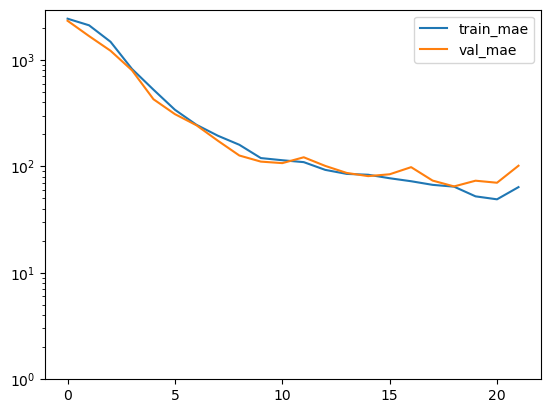

In [9]:
epochs = 30
lr = 1e-2
lr_schedule = OneCycleScheduler(lr, train_steps_per_epoch)

log_dir = "logs/fit/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# Define the Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor for early stopping
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the best model weights based on the monitored metric
)

# Define the ModelCheckpoint callback to save the best model during training
checkpoint = ModelCheckpoint(
    'best_model.h5',  # Filepath to save the best model
    monitor='val_loss',  # Metric to monitor for saving the best model
    save_best_only=True  # Save only the best model based on the monitored metric
)

history = model.fit(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=epochs,
          validation_data=val_generator, validation_steps=val_steps, callbacks=[lr_schedule, tensorboard_callback, early_stopping, checkpoint])

# Plot the training and validation loss and MAE
plt.semilogy(history.history['mae'], label='train_mae')
plt.semilogy(history.history['val_mae'], label='val_mae')
plt.ylim(ymin=1)  # Set the y-axis minimum value to 0
plt.legend()
plt.show()

In [7]:
Epoch 10/10
18/18 [==============================] - 146s 8s/step - loss: 1.8419e-04 - mae: 0.0107 - val_loss: 8.4897e-05 - val_mae: 0.0076

Epoch 3/10 - tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=4)(x, x, x)
144/144 [==============================] - 24s 165ms/step - loss: 8.0584e-04 - mae: 0.0217 - val_loss: 3.0579e-05 - val_mae: 0.0041

Epoch 18/10 - tf.keras.layers.MultiHeadAttention(num_heads=2, key_dim=4)(x, x, x) (No multiheadattention dropout)
144/144 [==============================] - 33s 233ms/step - loss: 3.2141e-05 - mae: 0.0039 - val_loss: 1.5543e-05 - val_mae: 0.0025

Epoch 5/30
144/144 [==============================] - 33s 230ms/step - loss: 2.5526e-04 - mae: 0.0129 - val_loss: 2.5898e-05 - val_mae: 0.0039

Epoch 11/30 - tf.keras.layers.MultiHeadAttention(num_heads=24, key_dim=64)(x, x, x) (No multiheadattention dropout)
144/144 [==============================] - 79s 546ms/step - loss: 4.5514e-05 - mae: 0.0047 - val_loss: 1.5869e-05 - val_mae: 0.0026


Epoch 21/30 - tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x, x) - batchnorm after inputs
144/144 [==============================] - 38s 262ms/step - loss: 2.1482e-05 - mae: 0.0028 - val_loss: 1.6468e-05 - val_mae: 0.0024

Epoch 18/30 - same as above but both LSTMs are 32
140/140 [==============================] - 83s 593ms/step - loss: 2.0085e-05 - mae: 0.0028 - val_loss: 1.9584e-05 - val_mae: 0.0028

SyntaxError: invalid decimal literal (417011211.py, line 2)

In [ ]:
test_generator.gen

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

model = tf.keras.models.load_model('best_model.h5')
test_steps = len(test_indices) // batch_size

# Step 4: Calculate Importance
def calculate_feature_importance(model, data_generator, metric, num_samples):
    # Get the initial performance of the model
    initial_predictions = model.predict(data_generator, steps=test_steps)
    initial_score = metric(get_targets(data_generator), initial_predictions)

    num_features = df_1B.shape[1]
    importance_scores = np.zeros(num_features)

    for feature_idx in range(num_features):
        # Shuffle the values of the selected feature
        shuffled_generator = data_generator.shuffle_feature(feature_idx)

        # Generate num_samples samples with the shuffled feature
        X_shuffled, y_shuffled = generate_samples(shuffled_generator, num_samples)

        # Make predictions using the shuffled data
        shuffled_predictions = model.predict(X_shuffled, steps=len(X_shuffled) // batch_size)

        # Calculate the performance metric with the shuffled predictions
        shuffled_score = metric(y_shuffled, shuffled_predictions)

        # Calculate the feature importance as the drop in performance
        importance_scores[feature_idx] = initial_score - shuffled_score

    return importance_scores

# Helper function to generate samples from the shuffled data generator
def generate_samples(data_generator, num_samples):
    X_samples = []
    y_samples = []

    for _ in range(num_samples):
        X_sample, y_sample = next(data_generator)
        X_samples.append(X_sample)
        y_samples.append(y_sample)

    X_samples = np.concatenate(X_samples)
    y_samples = np.concatenate(y_samples)

    return X_samples, y_samples

def get_targets(data_generator):
    targets = []
    for i in range(len(test_indices)):
        _ , y = next(data_generator)
        targets.append(y)
    return targets

# Step 5: Repeat and Average
def repeat_and_average(model, data_generator, metric, num_iterations, num_samples):
    num_features = df_1B.shape[1]
    importance_scores_sum = np.zeros(num_features)

    for _ in range(num_iterations):
        importance_scores = calculate_feature_importance(model, data_generator, metric, num_samples)
        importance_scores_sum += importance_scores

    # Calculate the average importance scores across iterations
    importance_scores_avg = importance_scores_sum / num_iterations

    return importance_scores_avg

# Step 6: Rank the Features
def rank_features(importance_scores):
    feature_indices = np.argsort(importance_scores)[::-1]
    ranked_features = [(index, importance_scores[index]) for index in feature_indices]

    return ranked_features

# Assuming you have your data generator ready (data_generator), you can use the following code to calculate feature importance:

# Calculate feature importance
num_iterations = 1  # Number of iterations for averaging importance scores
num_samples = 1  # Number of samples to generate for each feature permutation
importance_scores = repeat_and_average(model, test_generator, mean_squared_error, num_iterations, num_samples)

# Rank the features
ranked_features = rank_features(importance_scores)

# Print the ranked features
for feature_idx, importance_score in ranked_features:
    print(f"Feature #{feature_idx + 1}: Importance Score = {importance_score}")


In [18]:
test_generator.__copy__()

AttributeError: 'generator' object has no attribute '__copy__'

In [ ]:
test_generator = data_generator(df_1T, window_size, batch_size, test_indices)
test_steps = len(test_indices) // batch_size
# Generate predictions for the test set
predictions = model.predict(test_generator, steps=test_steps)
test_generator = data_generator(df_1T, window_size, batch_size, test_indices)
model.evaluate(test_generator, steps=test_steps)

#dates = df.iloc[test_indices].index.strftime("%Y-%m-%d")[:576]

# Extract the predicted high and low values
predicted_high = predictions[:, 0]
predicted_low = predictions[:, 1]

# Reset the test data generator to get actual values
test_generator = data_generator(df_1T, window_size, batch_size, test_indices, test=True)

# Get the actual high and low values
actual_high = []
actual_low = []
dates = df_1T.iloc[test_indices].index
x_test = []
for i in range(test_steps):
    x, batch_targets = next(test_generator)
    x_test.append(x)
    actual_high.extend(batch_targets[:, 0])
    actual_low.extend(batch_targets[:, 1])
    
    
# actual_high = np.exp(actual_high) * open_prices
# actual_low = np.exp(actual_low) * open_prices
# predicted_high = np.exp(predicted_high) * open_prices
# predicted_low = np.exp(predicted_low) * open_prices

# Print the individual predictions with actual values
# for i in range(len(predicted_high)):
#     print(f"Sample {i+1} - {dates[i]} - Predicted/Actual High: {predicted_high[i]:.2f}, {actual_high[i]:.2f} Predicted/Actual Low: {predicted_low[i]:.2f}, {actual_low[i]:.2f}")


In [45]:
df_es = pd.read_csv('es-1m_bk.csv', sep=';', names=['date', 'time', 'open', 'high', 'low', 'close', 'vol'])
df_es['datetime'] = pd.to_datetime(df_es.date + ' ' + df_es.time, format='%d/%m/%Y %H:%M')
df_es = df_es.infer_objects()
df_es.set_index(df_es.datetime, inplace=True)
df_es.index = df_es.index.tz_localize('America/Chicago').tz_convert('America/New_York')
df_es.drop(columns=['date', 'time', 'datetime', 'vol'], inplace=True)
df_es = df_es[~df_es.index.duplicated(keep='last')]

In [59]:
for d,ph,h,pl,l in zip(test_indices, predictions[:, 0], actual_high, predictions[:, 1], actual_low):
    print(df_1T.iloc[d].name.date(), ph, h, pl, l)

2013-11-05 1690.3889 1698.2906 1680.7097 1689.3636
2022-06-29 4021.2473 3920.2227 3984.2542 3880.663
2016-02-04 1891.1135 1919.5045 1884.5809 1891.5372
2015-11-10 1953.7242 2064.5012 1946.3475 2054.0542
2016-11-08 2082.936 2161.5842 2075.5056 2142.1243
2022-03-25 4352.5317 4633.8257 4315.212 4587.1196
2017-04-18 2354.1582 2378.6548 2344.175 2365.719
2023-01-19 3952.389 3965.971 3914.7996 3933.709
2016-05-31 2086.5173 2109.3171 2078.8132 2100.0327
2022-11-01 4004.5593 3988.8186 3966.6843 3915.888
2017-08-02 2552.015 2514.399 2540.082 2501.7039
2011-12-23 1171.9885 1177.3469 1161.9968 1171.0221
2017-12-21 2746.6707 2735.159 2730.4626 2726.0208
2015-01-29 1962.9363 1967.0001 1954.5142 1948.0796
2023-03-22 4061.578 4047.5 4023.3 4029.0
2014-10-08 1850.9159 1894.3276 1842.7634 1878.8988
2018-10-23 2833.7427 2751.866 2811.6272 2720.2905
2018-09-04 2927.3855 2936.2598 2905.149 2921.3306
2019-11-27 3164.414 3162.0676 3139.9993 3156.292
2011-09-28 1112.1592 1099.8135 1101.4188 1084.4249
2022-09